# Lab 1.5 Analysis
** Jason Chou **
<br>
- Goal: Make fully calibrated HR diagrams from G and B colors for M3 (globular cluster) and M67 (old open cluster)
- Todo: Error propagation from coadded and flux-corrected "batches" of observations. The flux correction is done via differential photometry determined by a reference star (with known "true" magnitudes) in each cluster, within the same FOV.

In [136]:
%%capture
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/afs/ir.stanford.edu/class/physics100/workdir/g2/Jason/codes/")

import pyfits
import numpy as np
import matplotlib.pyplot as plt
import photometry as pho
from util import *
from clusterHRdiag_new import *
from matplotlib.colors import LogNorm
% matplotlib inline

## Prelude 
### Preparations
#### 1. Calibrations
- M67: Done by Chun-Hao
- M3: Done by Eric

#### 2. Coaddition and uncertainty calculation for error of counts
<p style="text-indent: 40px">In here, coaddition includes creating batches of images (10 images per batch) and combine the batches via formal estimation of errors:<br><br>
$$N = \sqrt{F_\text{obj}\times t+F_\text{sky}\times t\times n+D\times t\times n+RN^2\times n}$$
<p style="text-indent: 40px">where each term is given in counts of photons (i.e. after multiplying gain) and per pixel for all but the object total flux.

_Done by Chun-Hao and Eric for the two clusters as in 1. This time, as suggested by Emil in Lab 1.3, the masking criterion for the SExtractor flag was set to higher values to preserve enough data points_<br><br>

### In this notebook
#### 3. Flux correction
<p style="text-indent: 40px">After identifying the reference stars with "true" color magnitudes in the fields, we then perform differential photemetry as defined in Lab 1.4:<br><br>
$$m_\text{true,obj}-m_\text{raw,obj}=m_\text{true,ref}-m_\text{raw,ref}$$
<p style="text-indent: 40px">Since the latter three are known, one can deduce the first term, with proper error propagation 
<p style="text-indent: 40px">-- combining batches and arithmetics in the equation above

#### 4. Color-Magnitude diagram
<p style="text-indent: 40px">Finally, plotting out the color ($\equiv \text{mag}_B-\text{mag}_G$) versus magnitude ($\equiv\text{mag}_G$) yields the HR diagram of interest


_Corresponding directories for Chun-Hao and Eric's work can be found in their directories for Lab 1.5. The former one is_ `/afs/ir.stanford.edu/class/physics100/workdir/g2/chto/Lab1.5` _and the latter_ `/afs/ir.stanford.edu/class/physics100/workdir/g2/eric/Lab1_5`

---
## M3

### Flux correction

In [66]:
workdir = "/afs/ir.stanford.edu/class/physics100/workdir/g2/Jason/Lab1.5/"
cadddir = "/afs/ir.stanford.edu/class/physics100/workdir/g2/M3/coadd_batch/"
batches = cadddir+"M3_G_coadd_batch{0}.fits"
target  = "M3"

Our catalog:

Median of FWHM is 2.810


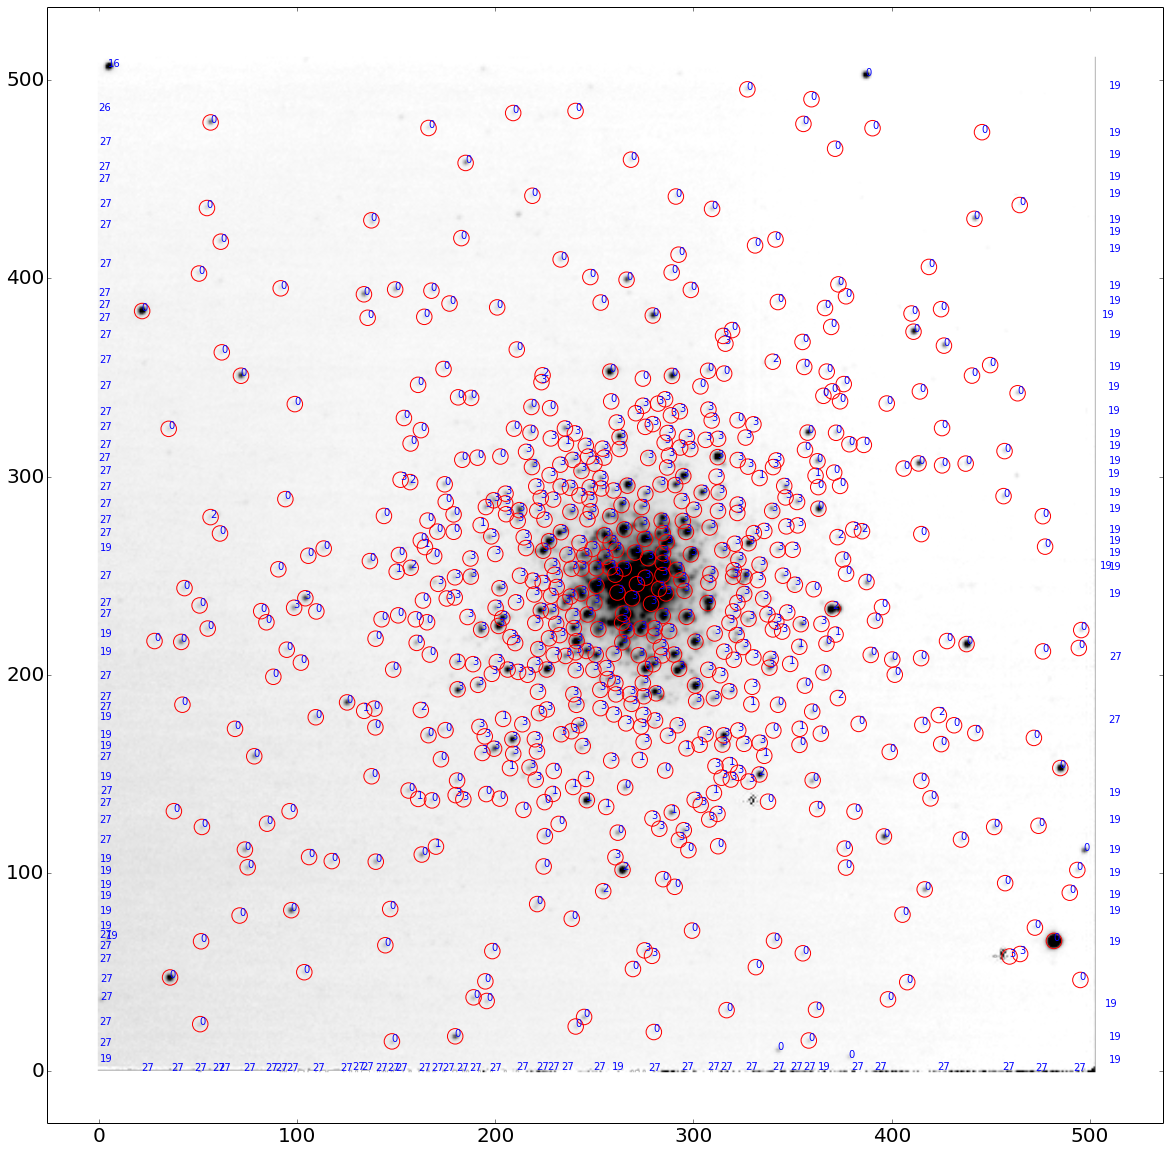

In [37]:
catData_mask, fwhmMedian, cat = disp_catalog(workdir,cadddir,batches,target,flagthr=8,edge=15,vmin=50,vmax=1000,stupidthing=10)

### Determine the aperture for background
Finding the best radius where the background is most likely described by a constant. The probabality is computed with the "survival function" in `scipy`'s `chi2` options

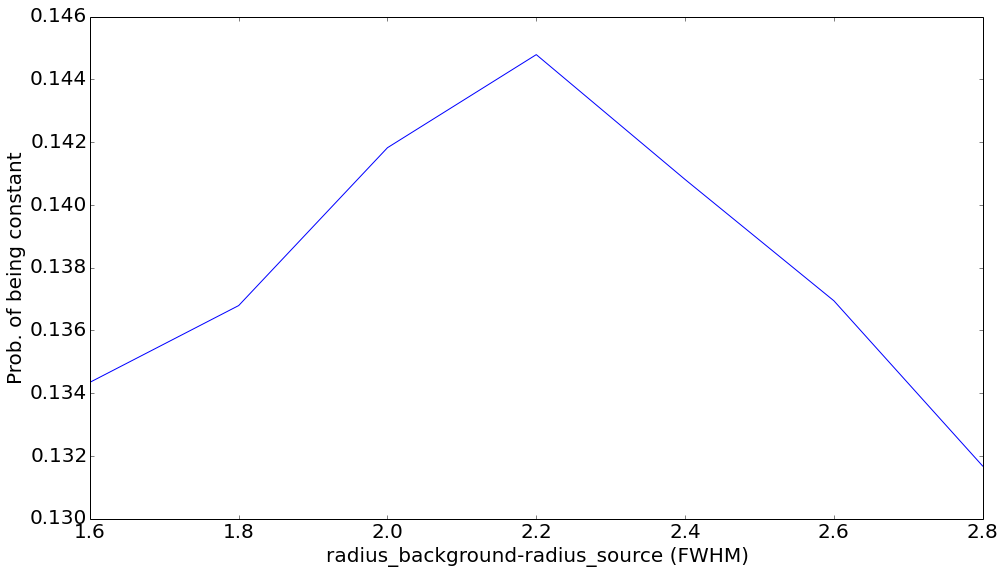

In [50]:
M3_max_r = bgd_prob_plot(catData_mask,workdir,cadddir,batches,
                         radlim_steps=(1.6,3.0,0.2),gain=6.,
                         fwhmMedian=fwhmMedian,stupidthing=10)

### Reference star
From `Aladin` or otherwise, we could confirm that the reference star `BD+29 2448` is indexed 599 in our catalog.

In [51]:
ref_idx = 599

And we want to refer to its flux at the "best" radius provided above. So

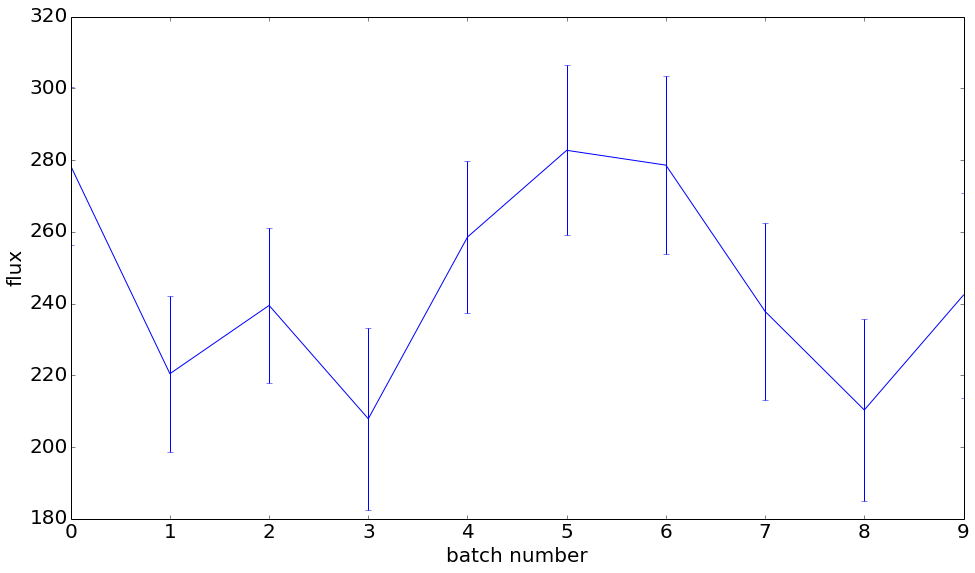

In [63]:
flux_of_ref_star(catData_mask,workdir,cadddir,batches,ref_idx,gain=6.,
                 max_r=M3_max_r,fwhmMedian=fwhmMedian,stupidthing=10)

### Cataloging the corrected magnitude (differential photometry)
The differential photometry and error propagation are hidden in the `photometry` script.
All we need to provide here is the information of the reference star:

In [65]:
refStarInf = [[599,9.8],[599,10.94]]

In [ ]:
corr_catalog(cat,workdir,cadddir,batches,target=target,refStarInf=refStarInf,
             gain=6.,max_r=M3_max_r,fwhmMedian=fwhmMedian,stupidthing=10)

### Color-Magnitude Diagram
Finally we can read the catalog just created and plot the full diagram, with error bars!<br><br>
Making another catalog with "color":

In [69]:
color_cat(target=target)

invalid value encountered in greater_equal


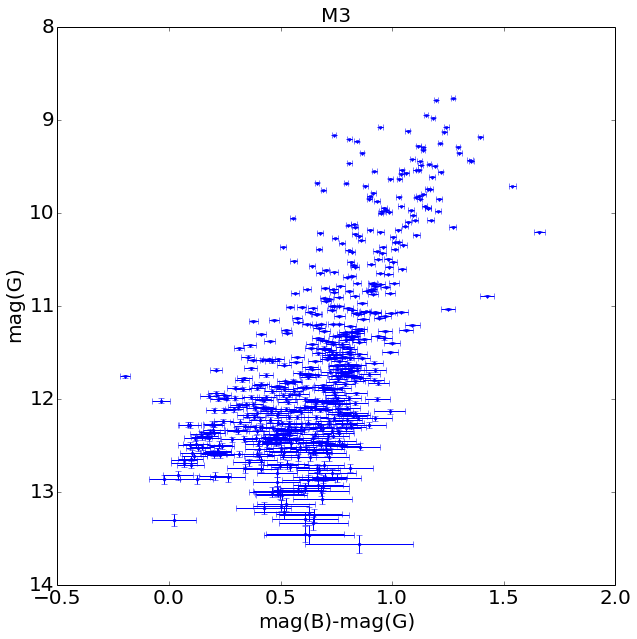

In [76]:
HR_diagram(target=target)

## Conclusion for M3

1. Compared to what I obtained back in Lab 1.3 (with much fewer stars. Thanks to Emil for pointing this out!), the image gets much "deeper" in terms of the y-axis magnitude (cf. [Lab1.3](https://nbviewer.jupyter.org/github/Mipanox/PHYS301/blob/master/Lab1.3/lab1_3.ipynb)), a clearer red giant branch is seen. On the contrary, the suspicious turn-off point disappears, due to: 
2. The larger errors of the fainter stars and the exaggeration of in the vertical direction. 
3. Again juxtaposing the "true" HR diagram, given that M3 is located at roughly 10kpc away ([wiki](https://en.wikipedia.org/wiki/Messier_3)), we can translate the diagram above into its "correct" form:<br><br>

_Note: I could not find any reference for the distance of BD+29 2448, so I'm guessing..._
<img src="http://spiff.rit.edu/classes/phys230/lectures/hr/hip_vabs_chart.gif"></img>

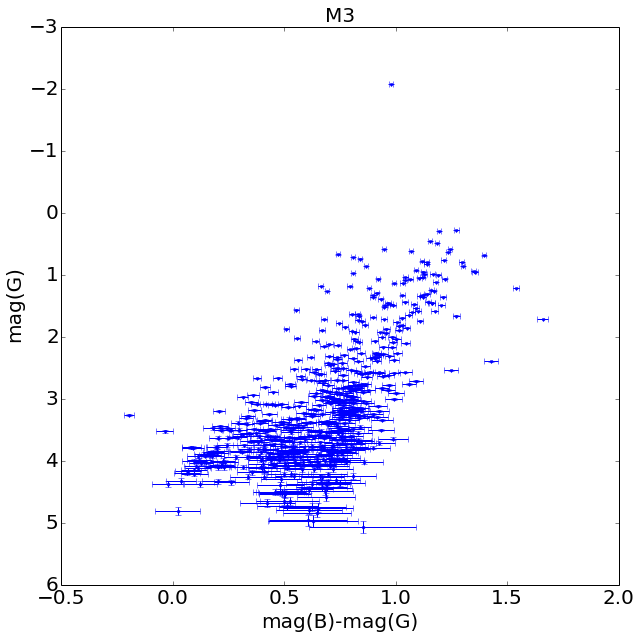

In [147]:
HR_diagram(target='M3',dist=1e4,dist_ref=200)

Apparently, we never saw the main sequence, as per [NASA](https://ase.tufts.edu/cosmos/print_images.asp?id=49)'s credible source for the HR diagrams of the clusters. And we've lost all the brightest stars because we removed them (the central region).
<img src="https://ase.tufts.edu/cosmos/pictures/stars/Fig8_9Open_star_clusters_in_the_H-R_diagram.jpg"></img>

_Actually I'm a bit confused. Are the magnitudes for the reference stars given in ABSOLUTE or APPARENT magnitudes? If they are the apparent magnitudes, then M67's diagram would seem wrong (after correcting for both M67 and HD 75700's distances). Contrarily, M3's diagram would be nonsense if they were absolute magnitudes. Hence I'm treating the two clusters differently in this notebook..._

---
## M67

### Flux correction

In [89]:
workdir = "/afs/ir.stanford.edu/class/physics100/workdir/g2/Jason/Lab1.5/"
cadddir = "/afs/ir.stanford.edu/class/physics100/workdir/g2/M67/coadd_batch/"
batches = cadddir+"M67_G_coadd_batch{0}.fits"
target  = "M67"

Catalog again

Median of FWHM is 4.142


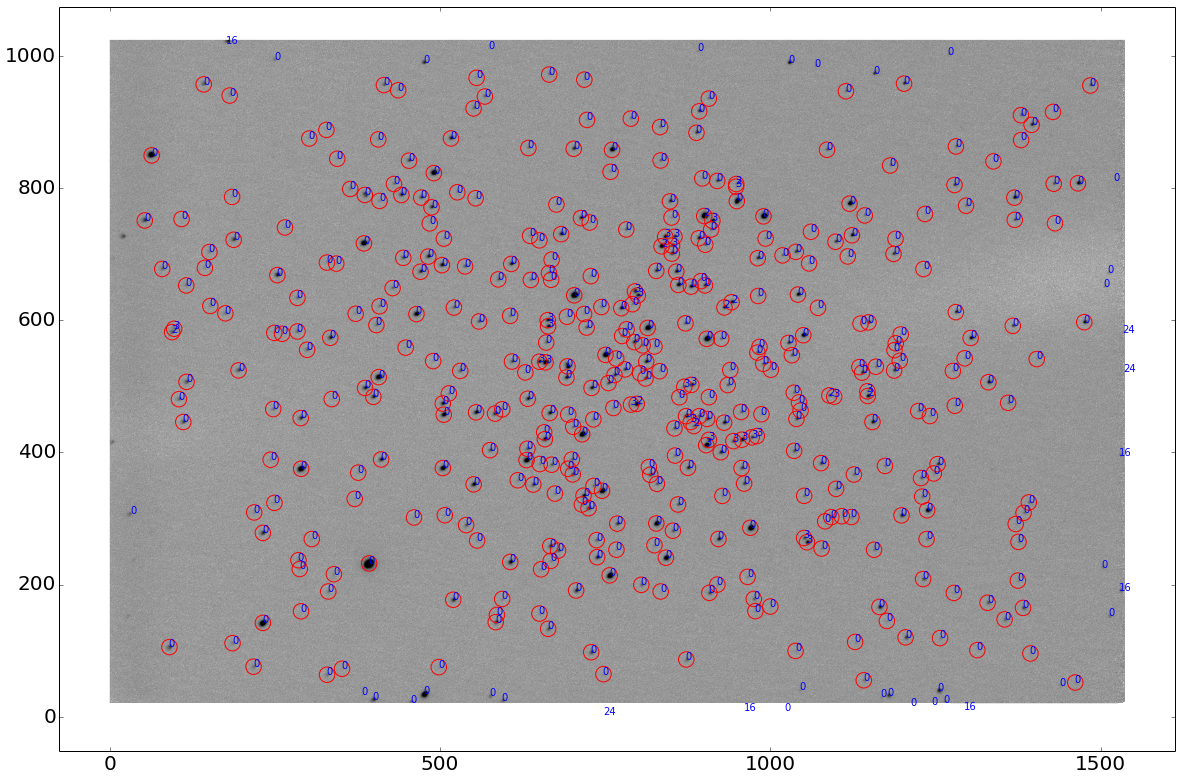

In [96]:
catData_mask, fwhmMedian, cat = disp_catalog(workdir,cadddir,batches,target,
                                             flagthr=4,edge=50,vmin=50,vmax=500)

### Determine the aperture for background
Don't forget to change the gain...

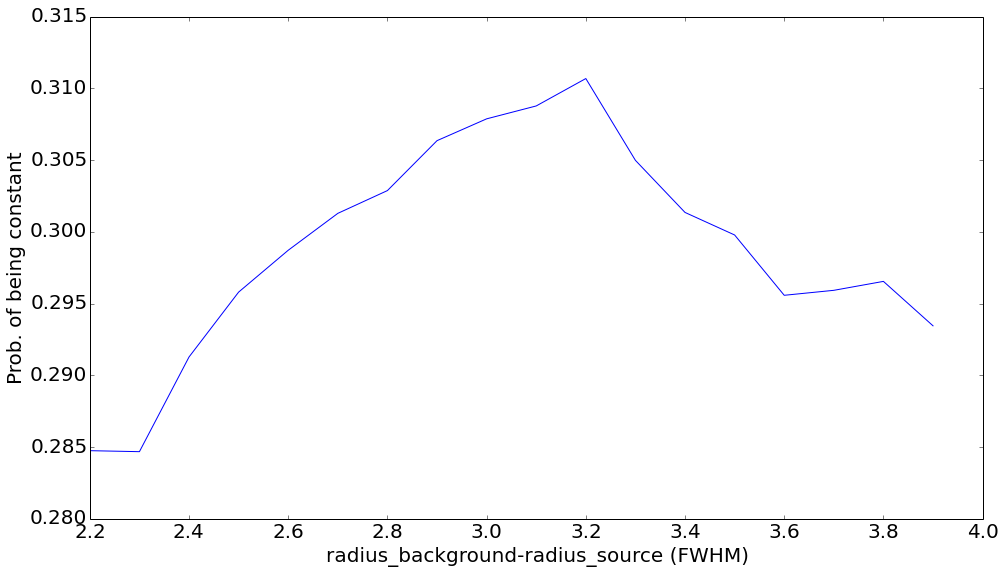

In [103]:
gain = 1.5
M67_max_r = bgd_prob_plot(catData_mask,workdir,cadddir,batches,
                          radlim_steps=(2.2,4.0,0.1),
                          gain=gain,fwhmMedian=fwhmMedian)

### Reference star
From `Aladin` or otherwise, we could confirm that the reference star `HD 75700` is indexed 354 in our catalog, and is ~226 pc away ([reference](http://server3.sky-map.org/starview?object_type=1&object_id=186520&object_name=HIP+43519&locale=PL)).

In [108]:
ref_idx = 354

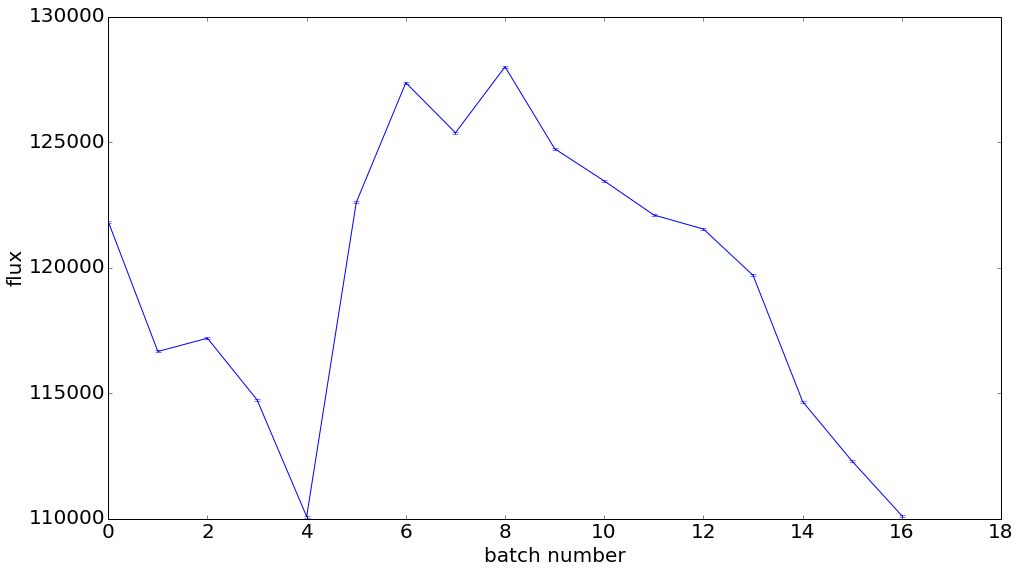

In [109]:
flux_of_ref_star(catData_mask,workdir,cadddir,batches,ref_idx,gain=gain,
                 max_r=M67_max_r,fwhmMedian=fwhmMedian)

### Cataloging the corrected magnitude (differential photometry)
Information of the reference star:

In [110]:
refStarInf = [[ref_idx,7.872],[ref_idx,8.97]]

And the magnitude catalog as well as colored catalog

In [ ]:
corr_catalog(cat,workdir,cadddir,batches,target=target,refStarInf=refStarInf,
             gain=gain,max_r=M67_max_r,fwhmMedian=fwhmMedian)

In [112]:
color_cat(target=target)

### HR diagram
This time I'll input the known distances. (For M67 it's around 850 pc ([wiki](https://en.wikipedia.org/wiki/Messier_67)) and HD 75700 is taken to be 230 pc; see above)

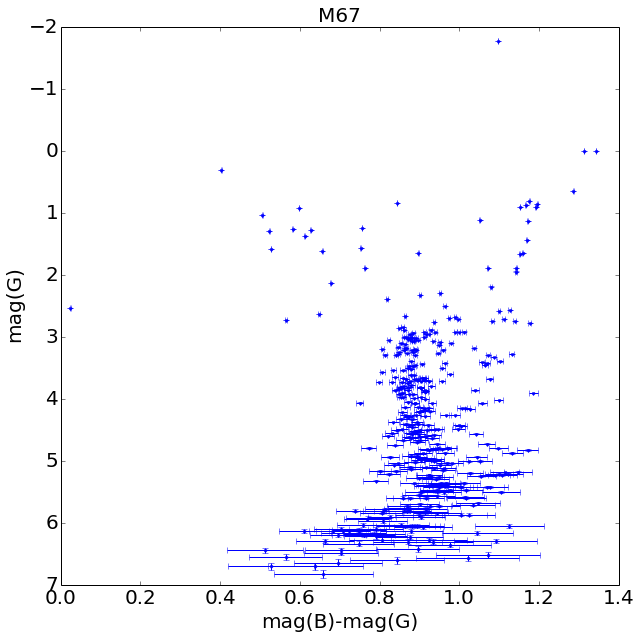

In [131]:
HR_diagram(target=target,dist=850.)

## Conclusion for M67
_(We largely share the same conclusions here, especially for estimating age)_


1. The main sequence is much clearer thanks to more images (deeper in the same sense as Hubble's...)

2. The error bars are longer as compared to M3 -- fainter means more uncertain

3. If we assume all the stars in the cluster form at the same time, we can calculate the age of the cluster. 
<br><br>

The way to do this is to estimate the age of the star at the turn-off point (by knowing how long it takes to use up all the hydrogen), and we assume that the cluster has the same age as that star. 

Following this [website](http://voyager2.dvc.edu/faculty/kcastle/Analyzing%20Star%20Cluster%20Color%20Magnitude%20Diagrams.htm), 
first we calculate the mass of the star at turn off point:

<p style="text-indent: 40px">The absolute magnitude for that star is ~2.3<br>
<p style="text-indent: 40px">The mass is then calculated by  
$$
\frac{m_\text{star}}{m_\bigodot}=10^{-0.1(ABMag-4.85)} \approx 1.7
$$

<p style="text-indent: 40px">And the age of the star is roughly 

$$
\frac{T}{yrs}=10^{10} \left(\frac{\text{mass}_\text{star}}{m_\bigodot}\right)^{-3}
$$

<p style="text-indent: 40px">So the age of the star is $2\times10^9$ years. 

For [reference](https://en.wikipedia.org/wiki/Messier_67), the age of the cluster is estimated to be 3.2 billion years.